In [157]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from tiny_ta import atr, rsi, sma

# End of the Month - Strategie im S&P 500

Zunächst werden die Kursdaten für den S&P 500 geladen und bereinigt

In [158]:
SYMBOL = "^GSPC"
SYMBOL = "SPY"

stock = yf.download(SYMBOL)

stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

[*********************100%%**********************]  1 of 1 completed


Der VIX für die Volatilität wird als externer Indikator mit betrachtet

In [159]:
vix = yf.download("^VIX")
vix["vix"] = vix["Close"]
stock = pd.merge(
    stock,
    vix[
        [
            "vix",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Die 5 jährigen Staatsanleihen werden ebenfalls mit betrachtet

In [160]:
yield_5_years = yf.download("^FVX")

yield_5_years["yield_5yr"] = yield_5_years["Close"]
stock = pd.merge(
    stock,
    yield_5_years[
        [
            "yield_5yr",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Ein paar Indikatoren für spätere Auswertungen

In [161]:
stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["month"] = stock.index.month

Markiere die letzten x Tage und ersten x Tage im Monat für die geplanten Trades. 

In [162]:
days = 5

# Identify end of month
end_of_month = stock.groupby([stock.index.year, stock.index.month]).tail(days)

# Identify beginning of month
beginning_of_month = stock.groupby([stock.index.year, stock.index.month]).head(days)

# add countdown
end_of_month["countdown"] = -1
end_of_month["days"] = end_of_month["countdown"].cumsum().add(1).mod(days)
end_of_month.loc[end_of_month.days == days, "days"] = 0
end_of_month["days"] = (end_of_month["days"].add(1)) * -1

beginning_of_month["countdown"] = 1
beginning_of_month["days"] = beginning_of_month["countdown"].cumsum().sub(1).mod(days)
beginning_of_month.loc[beginning_of_month.days == 0, "days"] = days

# Combine the results
marked_days = pd.concat([end_of_month, beginning_of_month])
marked_days["hold"] = 1

df = pd.merge(
    left=stock,
    right=marked_days[["hold", "days"]],
    left_index=True,
    right_index=True,
    how="left",
)

df.hold = df.hold.fillna(0)

df["buy"] = np.where(
    (df.hold.shift(1) == 0) & (df.hold == 1),
    1,
    np.where((df.hold == 1) & (df.hold.shift(-1) == 0), -1, np.nan),
)

df.hold = np.where(df.hold == 1, df.Low, np.nan)

## Jetzt zur Strategie
Es wird 5 Tage vor Monatsende gekauft und 5 Tage nach Monatsanfang gekauft

In [163]:
from backtesting import Strategy


class end_of_month(Strategy):
    """
    strategy for trend_trading
    """

    days_before = -5
    days_after = 5

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

        self.vix = self.I(lambda: self.data.vix, name="VIX", overlay=False)
        self.yield_5yr = self.I(
            lambda: self.data.yield_5yr, name="Yield 5", overlay=False
        )

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if self.data.days[-1] == self.days_before:
            self.buy()

In [164]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":], end_of_month, cash=100_000, commission=0.002, trade_on_close=True
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   47.966157
Equity Final [$]                194847.413302
Equity Peak [$]                 200923.047199
Return [%]                          94.847413
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                    5.622461
Volatility (Ann.) [%]               11.498037
Sharpe Ratio                         0.488993
Sortino Ratio                        0.741214
Calmar Ratio                          0.32456
Max. Drawdown [%]                  -17.323349
Avg. Drawdown [%]                   -1.868953
Max. Drawdown Duration      916 days 00:00:00
Avg. Drawdown Duration       54 days 00:00:00
# Trades                                  148
Win Rate [%]                        61.486486
Best Trade [%]                       8.931603
Worst Trade [%]                    -15.184761
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

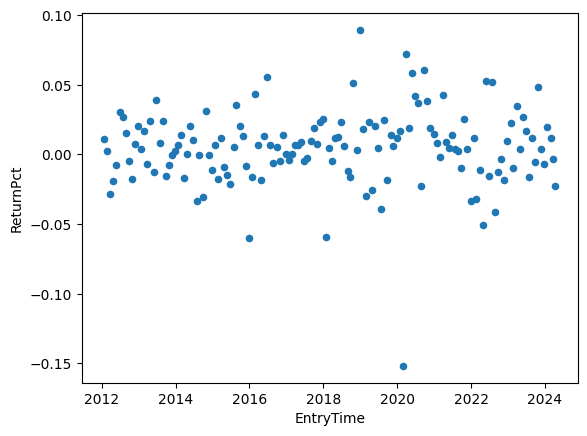

In [165]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

In [166]:
trades[trades.ReturnPct < -0.05]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
47,546,995,1004,205.269721,193.009995,-6693.810453,-0.059725,2015-12-28,2016-01-11,14 days
72,448,1514,1523,284.818500,268.010010,-7530.203625,-0.059015,2018-01-26,2018-02-08,13 days
97,445,2032,2041,324.587882,275.299988,-21933.113121,-0.151848,2020-02-25,2020-03-09,13 days
123,413,2577,2586,426.681647,405.100006,-8913.217503,-0.050580,2022-04-26,2022-05-09,13 days


Vielleicht wäre ein Stopp doch hilfreich

In [167]:
class end_of_month_with_SL(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if trade.pl_pct < -0.06:
                    trade.close()

                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [168]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":],
    end_of_month_with_SL,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                     47.6082
Equity Final [$]                193404.017021
Equity Peak [$]                 199444.048342
Return [%]                          93.404017
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                    5.558078
Volatility (Ann.) [%]               11.039476
Sharpe Ratio                         0.503473
Sortino Ratio                        0.770097
Calmar Ratio                         0.393414
Max. Drawdown [%]                  -14.127799
Avg. Drawdown [%]                   -1.888368
Max. Drawdown Duration      916 days 00:00:00
Avg. Drawdown Duration       54 days 00:00:00
# Trades                                  148
Win Rate [%]                        61.486486
Best Trade [%]                       8.931603
Worst Trade [%]                    -11.056442
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

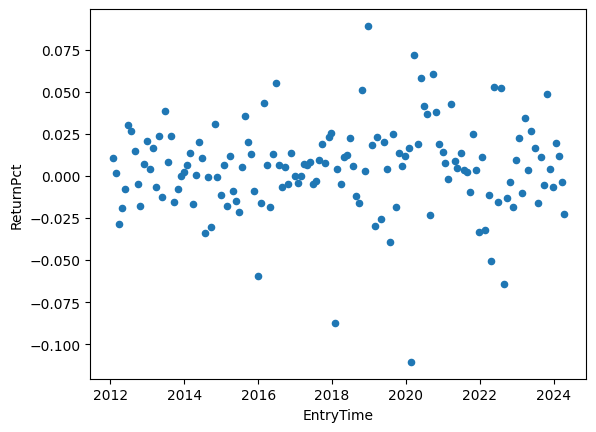

In [169]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

jetzt wird überprüft welche Tage für die Ein- und Ausstiege besser sein könnten.

In [170]:
stats, heatmap = bt.optimize(
    days_before=range(-5, 0, 1),
    days_after=range(1, 6),
    maximize="Profit Factor",  # "Equity Final [$]",
    max_tries=200,
    random_state=0,
    return_heatmap=True,
)

/Users/produktmanagement/Python/github/backtesting-trading-strategies/.venv/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [171]:
# heatmap
heatmap.sort_values().iloc[-3:]

days_before  days_after
-4           4             1.627363
-5           5             1.658252
-4           5             1.659052
Name: Profit Factor, dtype: float64

In [172]:
heatmap.groupby(["days_before", "days_after"]).mean().unstack()

days_after,1,2,3,4,5
days_before,,,,,
-5,1.154853,1.260741,1.349232,1.587650,1.658252
-4,1.235751,1.324846,1.402044,1.627363,1.659052
-3,1.068851,1.169776,1.253053,1.476185,1.531145
-2,0.887331,1.011699,1.106879,1.343949,1.403451
-1,0.692282,0.866219,0.985748,1.232504,1.255945


In [173]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   42.987309
Equity Final [$]                186832.038985
Equity Peak [$]                 192177.094839
Return [%]                          86.832039
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                    5.259244
Volatility (Ann.) [%]               10.733896
Sharpe Ratio                         0.489966
Sortino Ratio                        0.741442
Calmar Ratio                         0.300469
Max. Drawdown [%]                  -17.503467
Avg. Drawdown [%]                   -2.290499
Max. Drawdown Duration     1246 days 00:00:00
Avg. Drawdown Duration       63 days 00:00:00
# Trades                                  148
Win Rate [%]                        59.459459
Best Trade [%]                       6.228369
Worst Trade [%]                    -12.549974
Avg. Trade [%]                    

The Winner is ...

In [174]:
stats["_strategy"]

<Strategy end_of_month_with_SL(days_before=-4,days_after=5)>

In [175]:
# bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run(days_before=-4, days_after=5)
bt.plot(superimpose=False, open_browser=False)

Row(id='30982', ...)

In [176]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   42.987309
Equity Final [$]                186832.038985
Equity Peak [$]                 192177.094839
Return [%]                          86.832039
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                    5.259244
Volatility (Ann.) [%]               10.733896
Sharpe Ratio                         0.489966
Sortino Ratio                        0.741442
Calmar Ratio                         0.300469
Max. Drawdown [%]                  -17.503467
Avg. Drawdown [%]                   -2.290499
Max. Drawdown Duration     1246 days 00:00:00
Avg. Drawdown Duration       63 days 00:00:00
# Trades                                  148
Win Rate [%]                        59.459459
Best Trade [%]                       6.228369
Worst Trade [%]                    -12.549974
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [177]:
stats["Win Rate [%]"]

59.45945945945946

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [178]:
stats["Avg. Trade [%]"]

0.42358409749911896

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [179]:
stats["Profit Factor"]

1.659052386339893

In [180]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [181]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.05].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0252
2,0.0278
3,-0.0632
4,0.0497
5,-0.0398
6,0.1943
7,0.1668
8,0.0029
9,0.0735


<Axes: title={'center': 'Gewinner Trades'}>

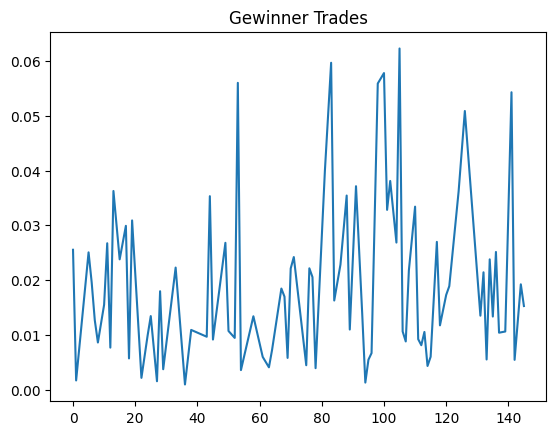

In [182]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

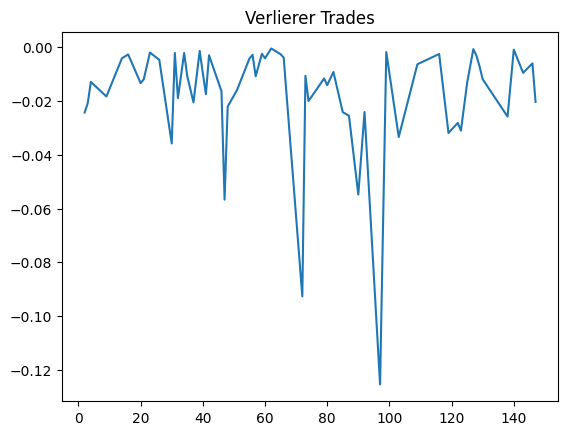

In [183]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [184]:
class end_of_month_and_skip_month(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [185]:
df

,Open,High,Low,Close,Adj Close,Volume,vix,yield_5yr,rsi_3,rsi_7,...,sma,sma_20,sma_50,sma_100,sma_200,sma_pct,month,hold,days,buy
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763733,1003200,12.420000,5.570,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,43.750000,-1.0,NaN
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763733,1003200,12.420000,5.570,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,43.750000,5.0,NaN
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939867,480500,12.330000,5.550,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,43.968750,1.0,NaN
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992706,201300,12.250000,5.630,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,44.125000,2.0,NaN
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256899,529400,12.120000,5.620,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,44.375000,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-10,513.479980,516.159973,512.090027,514.119995,514.119995,82652800,15.800000,4.615,25.0,39.0,...,518.10,0.992318,1.010774,1.052425,1.108208,0.99,4,512.090027,-5.0,1.0
2024-04-11,515.679993,519.479980,512.080017,518.000000,518.000000,70099000,14.910000,4.623,54.0,51.0,...,518.21,0.999595,1.017322,1.058872,1.115538,1.00,4,512.080017,-4.0,NaN
2024-04-12,514.369995,515.820007,509.079987,510.850006,510.850006,92469100,17.309999,4.533,26.0,36.0,...,518.00,0.986197,1.002178,1.042977,1.099264,0.99,4,509.079987,-3.0,NaN


In [186]:
bt = Backtest(
    df["2012-01-01":], end_of_month_and_skip_month, cash=100_000, commission=0.002
)
stats = bt.run(days_before=-4, days_after=5, skip_month=skip_month)
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='32529', ...)

In [187]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   17.865278
Equity Final [$]                195867.550392
Equity Peak [$]                 197383.074745
Return [%]                           95.86755
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                      5.6677
Volatility (Ann.) [%]                6.456323
Sharpe Ratio                         0.877853
Sortino Ratio                        1.471612
Calmar Ratio                         0.766835
Max. Drawdown [%]                   -7.391032
Avg. Drawdown [%]                   -1.490018
Max. Drawdown Duration      359 days 00:00:00
Avg. Drawdown Duration       61 days 00:00:00
# Trades                                   61
Win Rate [%]                        63.934426
Best Trade [%]                       6.228369
Worst Trade [%]                     -3.338146
Avg. Trade [%]                    

In [188]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)

In [189]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
4,0.0700
6,0.1943
7,0.1668
9,0.0735
11,0.1864


In [190]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.year).PnL.sum().round(1))

,PnL
ExitTime,
2012,-1847.8
2013,4119.5
2014,3829.2
2015,246.8
2016,6519.3
2017,3236.3
2018,5899.0
2019,15328.9
2020,25313.2


In [191]:
equity = stats["_equity_curve"]
equity.groupby(equity.index.year).Equity.last().round(1)

2012     98152.2
2013    102271.6
2014    106100.8
2015    106347.6
2016    112866.9
2017    116103.2
2018    122002.2
2019    137331.1
2020    162644.3
2021    176875.3
2022    174417.6
2023    197044.7
2024    195867.6
Name: Equity, dtype: float64